# Here goes the title
---

Some description.

*Code made by [You](https://github.com/@you) - YYYY.*

### Import required libraries

In [3]:
# IMPORT CONFIGs
import os
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../scripts')
from config import RAW_PATH, TREAT_PATH, OUTPUT_PATH


# DATA ANALYSIS & VIZ TOOLS
from copy import deepcopy

import pandas as pd
pd.options.display.max_columns = 999

import seaborn as sns
import matplotlib.pyplot as pl
import matplotlib.colors as colors 
# Para legenda com linhas:
from matplotlib import lines
# Para legenda com barras:
from matplotlib.patches import Patch

import plotly
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12)


# For changes in .py
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy



In [4]:
from utils import *

In [5]:
from other_module import *

# Objetivos

1. Filtrar nomes semi homonimos como 'Tito' e 'Tito da Silva'. 
2. Enumerar tipos de atividade
3. Agrupar tipos de atividade
4. Contar tipos de ativadade nos primeiros 100 dias de cada legislatura
5. Histograma dos parlamentares por atividade + ranking colunar
6. Atividades per capita por partido + Acredito
7. Repetir 5 e 6 para grupos de atividade

# Data

Os dados são consideravelmente grandes, por isso trabalharemos somente com os dados agregados.

In [6]:
raw_df_sample = query_gcp('SELECT * FROM `gabinete-compartilhado.analise_congresso_atividade.tramitacao_por_parlamentar_` LIMIT 100')

In [7]:
raw_df_sample.head(3)

,casa,id,sigla_tipo,numero,ano,data_hora,sequencia,sigla_orgao,uri_orgao,cod_situacao,regime,descricao_tramitacao,cod_tipo_tramitacao,descricao_situacao,despacho,ementa,nome_autor,sigla_partido_autor,sigla_uf_autor,keywords,url,id_parlamentar,nome_parlamentar,sigla_partido,sigla_uf,aday,diff,legislatura,data_displaced
0,camara,2196646,EMP,2,2019,2019-04-03 15:33:00,1,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,None,.,Apresentação de Proposição,100,None,Apresentação da Emenda de Plenário n. 2/2019 P...,,Pedro Lucas Fernandes,PTB,MA,None,http://www.camara.gov.br/proposicoesWeb/prop_m...,204566,MARRECA FILHO,Patriota,MA,2019-04-03,0,56,2019-04-03
1,camara,2183943,MPV,852,2018,2019-02-13 14:00:00,42,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,None,"Urgência (Art. 62, CF)",Obstruçao Votação (Plenário),1232,None,Votação do Requerimento do Dep. Ivan Valente (...,Dispõe sobre a transferência de imóveis do Fun...,Poder Executivo,,,"alteração, decreto-lei, isenção, pagamento, ta...",None,73531,IVAN VALENTE,PSOL,SP,2019-02-13,0,56,2019-02-13
2,camara,2183943,MPV,852,2018,2019-02-13 14:00:00,32,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,None,"Urgência (Art. 62, CF)",Encaminhamento da Votação,219,None,Encaminhou a Votação o Dep. Ivan Valente (PSOL...,Dispõe sobre a transferência de imóveis do Fun...,Poder Executivo,,,"alteração, decreto-lei, isenção, pagamento, ta...",None,73531,IVAN VALENTE,PSOL,SP,2019-02-13,0,56,2019-02-13


In [8]:
raw_df_sample.describe()

,id,numero,ano,sequencia,cod_tipo_tramitacao,id_parlamentar,diff,legislatura
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.00000,100.0,100.0
mean,2.171411e+06,238.780000,2018.400000,11.970000,298.840000,147351.94000,0.0,56.0
std,1.749806e+05,350.628572,1.172065,20.070308,324.716184,52782.35615,0.0,0.0
min,4.454000e+05,1.000000,2009.000000,1.000000,100.000000,69871.00000,0.0,56.0
25%,2.183943e+06,7.750000,2018.000000,1.000000,100.000000,74707.50000,0.0,56.0
50%,2.194330e+06,25.000000,2019.000000,2.000000,164.500000,160547.00000,0.0,56.0
75%,2.196629e+06,177.500000,2019.000000,10.000000,320.000000,204382.00000,0.0,56.0
max,2.199704e+06,872.000000,2019.000000,92.000000,1250.000000,204569.00000,0.0,56.0


# Analise

## 1. Filtrar semi homonimos

## 2. Enumerar tipos de atividade

In [9]:
desc_tramitacao = query_gcp(
"""SELECT descricao_tramitacao, count(*) as counta
FROM `gabinete-compartilhado.analise_congresso_atividade.tramitacao_por_parlamentar_` 
GROUP BY descricao_tramitacao
ORDER BY counta DESC""")

In [10]:
desc_tramitacao

,descricao_tramitacao,counta
0,Apresentação de Proposição,6349
1,Apresentação de Requerimento,4782
2,Designação de Relator,3114
3,Aprovação de Proposição Interna,1021
4,Parecer do Relator,820
5,Recebimento - Relator,765
6,Distribuição,656
7,Discussão da Materia pelos Deputados,636
8,Notificações,487
9,Adiamento de Discussão,208


### Atividades interessantes:
- Relatorias 
- Parecer de Relatoria
- Apresentação de Proposição grande (PL, PEC, PLC) 

## 5. Parlamentares por atividade

### Numero de parlamentares por partido

In [11]:
partido_bancada = query_gcp("""
SELECT sigla_partido, count(*) as numero_parlamentares
FROM `gabinete-compartilhado.congresso.camara_deputado_` 
WHERE ultima_legislatura = 56
GROUP BY sigla_partido
""")

In [12]:
partido_bancada = (pd.concat([partido_bancada, 
                             pd.DataFrame([{'sigla_partido': 'Acredito', 'numero_parlamentares': 2}])])
                .reset_index(drop=True))

In [13]:
partido_bancada.head(3)

,numero_parlamentares,sigla_partido
0,15,Solidariedade
1,32,PRB
2,28,PDT


In [117]:
deputados = query_gcp("""
SELECT nome_parlamentar, id
FROM `gabinete-compartilhado.congresso.camara_deputado_` 
WHERE ultima_legislatura = 56
""")

### Aggregate query

In [272]:
atividades_tramitacao = {
    'relatorias': "descricao_tramitacao = 'Designação de Relator' AND sigla_tipo IN ('PL', 'PEC', 'MPV', 'PLC')",
    'pareceres de relatoria': "(descricao_tramitacao = 'Parecer do Relator') AND sigla_tipo IN ('PL', 'PEC', 'MPV', 'PLC')",
    'requerimentos de informação': "descricao_tramitacao = 'Apresentação de Proposição' AND sigla_tipo = 'RIC'",
    'obstruções em plenário': "descricao_tramitacao = 'Obstrução Discussão (Plenário)'",
    'discussões de matéria': "(descricao_tramitacao = 'Discussão da Materia pelos Deputados' OR lower(despacho) like '%discutiu a matéria%')",
    'aprovações de requerimento': "descricao_tramitacao = 'Aprovação de Requerimento'",
    'requerimento de audiência pública': "descricao_tramitacao = 'Apresentação de Proposição' AND sigla_tipo = 'REQ' AND lower(despacho) LIKE '%audiência pública%'",
    # 'requerimento de urgência': "descricao_tramitacao = 'Apresentação de Proposição' AND sigla_tipo = 'REQ' AND lower(despacho) LIKE '%audiência pública%'",
    # 'apresentações de PDL': "descricao_tramitacao = 'Apresentação de Proposição' AND sigla_tipo = 'PDL'"
}

atividades_autores = {
    'apresentação PL' : 'PL',
    'apresentação PEC' : 'PEC',
    'apresentação PDL' : 'PDL',
    'apresentação REQ' : 'REQ',
}


---------------
apresentação PL
---------------
Deputados
Posicao Tabata 204
Posicao Rigoni 108


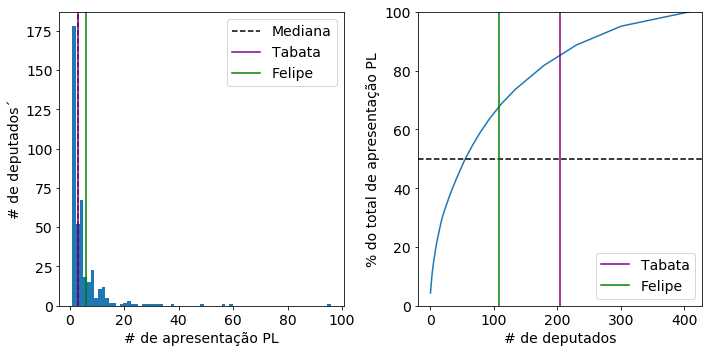

---------------
Partidos


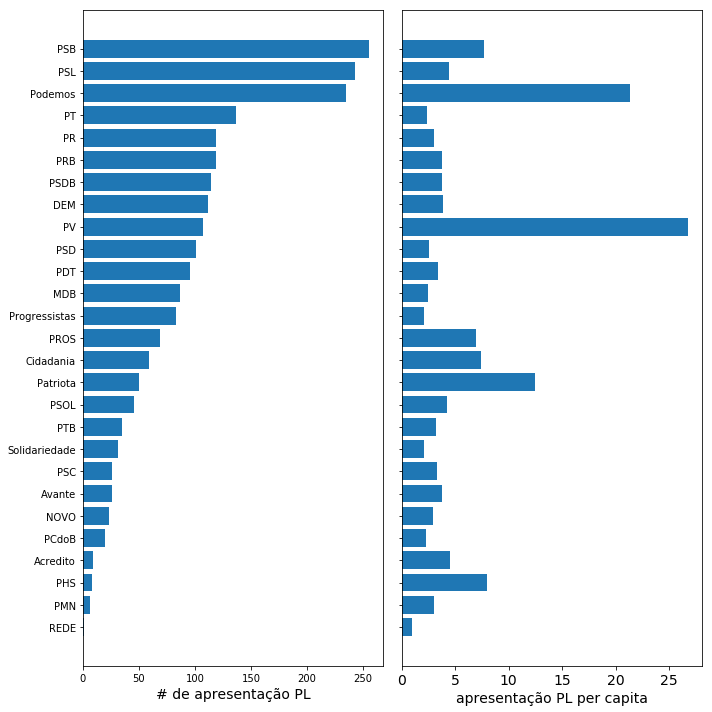

---------------
apresentação PEC
---------------
Deputados


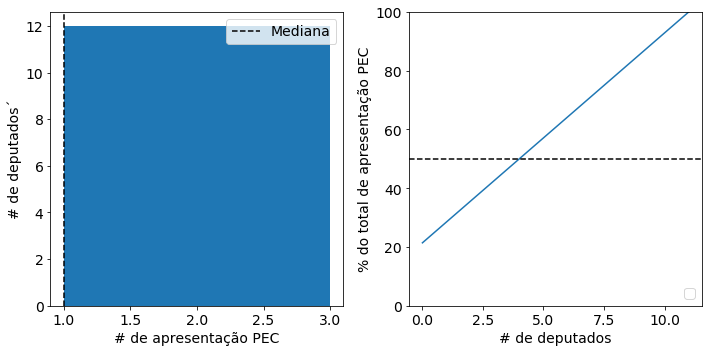

---------------
Partidos


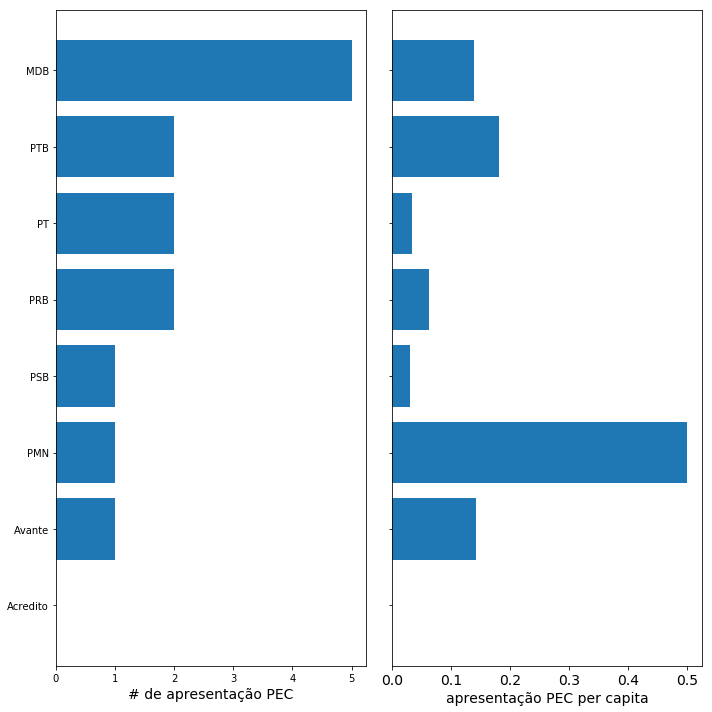

---------------
apresentação PDL
---------------
Deputados
Posicao Rigoni 27


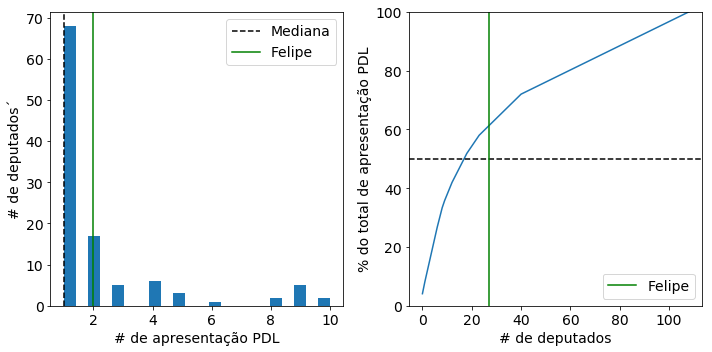

---------------
Partidos


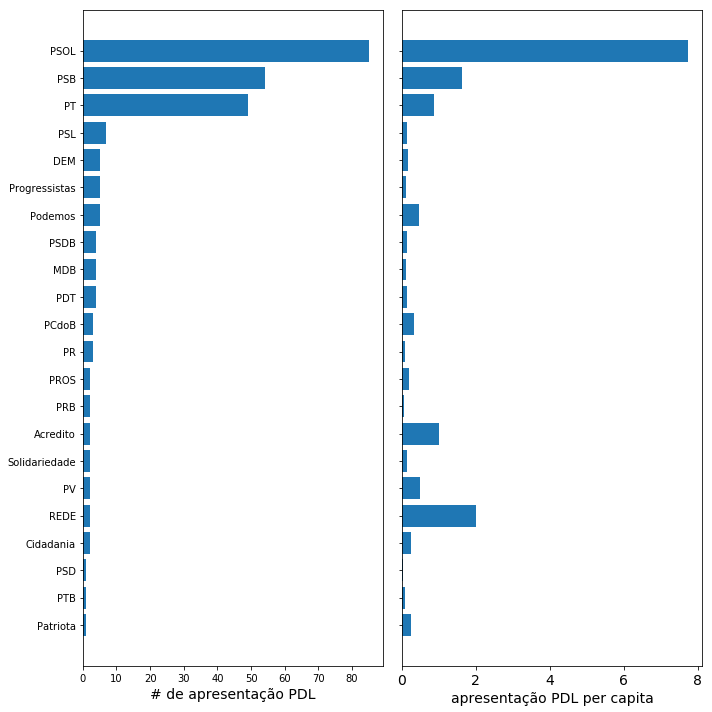

---------------
apresentação REQ
---------------
Deputados
Posicao Tabata 245
Posicao Rigoni 265


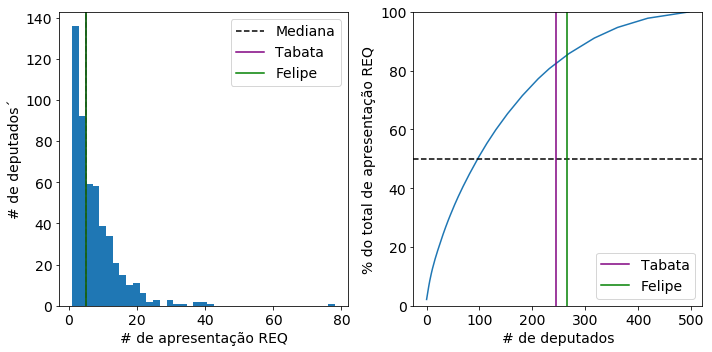

---------------
Partidos


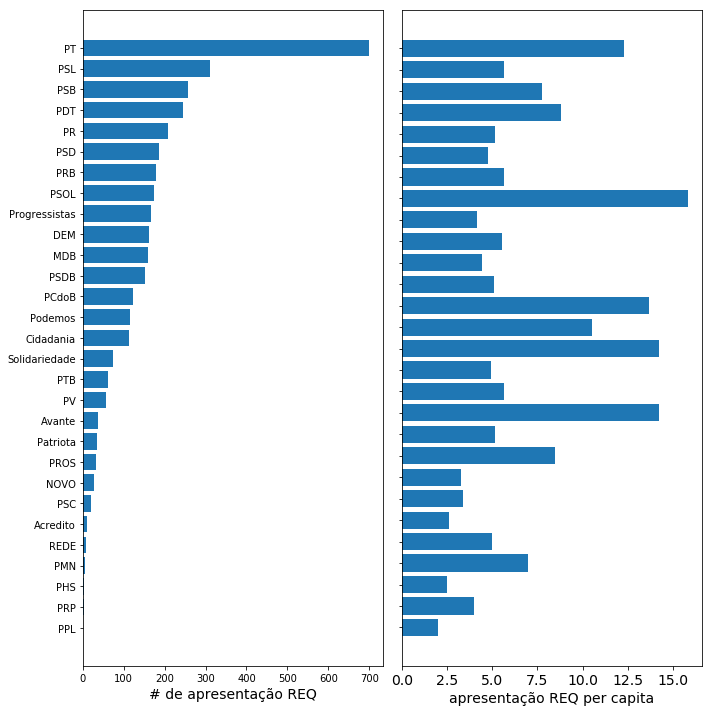

---------------
relatorias
---------------
Deputados
Posicao Tabata 49
Posicao Rigoni 40


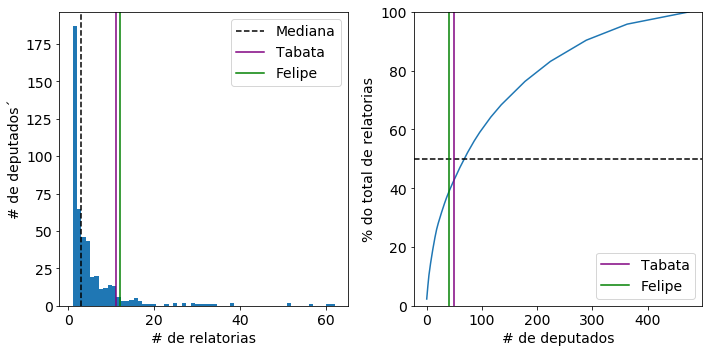

---------------
Partidos


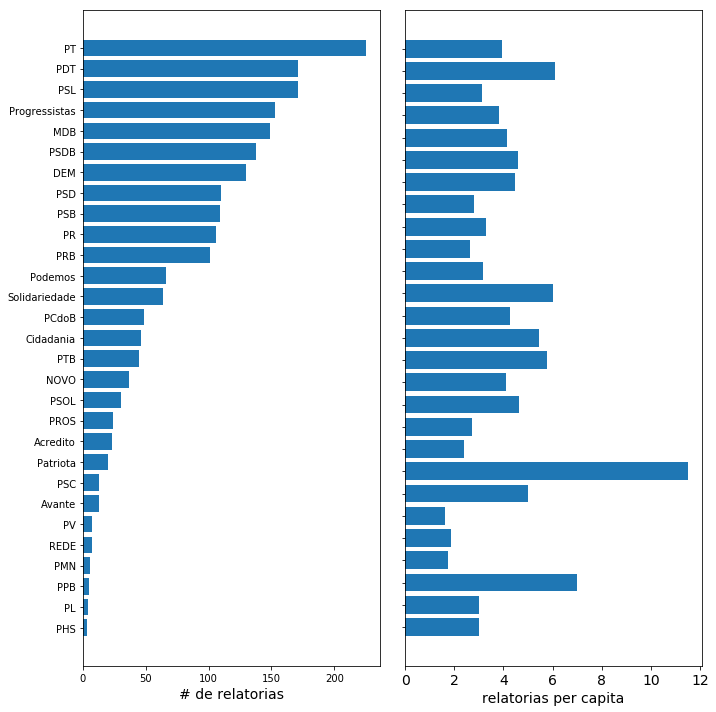

---------------
pareceres de relatoria
---------------
Deputados
Posicao Rigoni 22


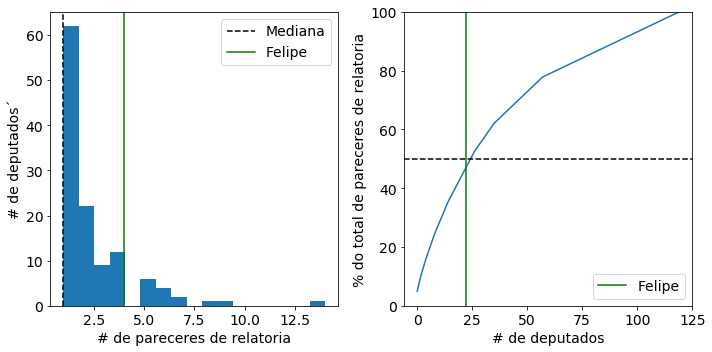

---------------
Partidos


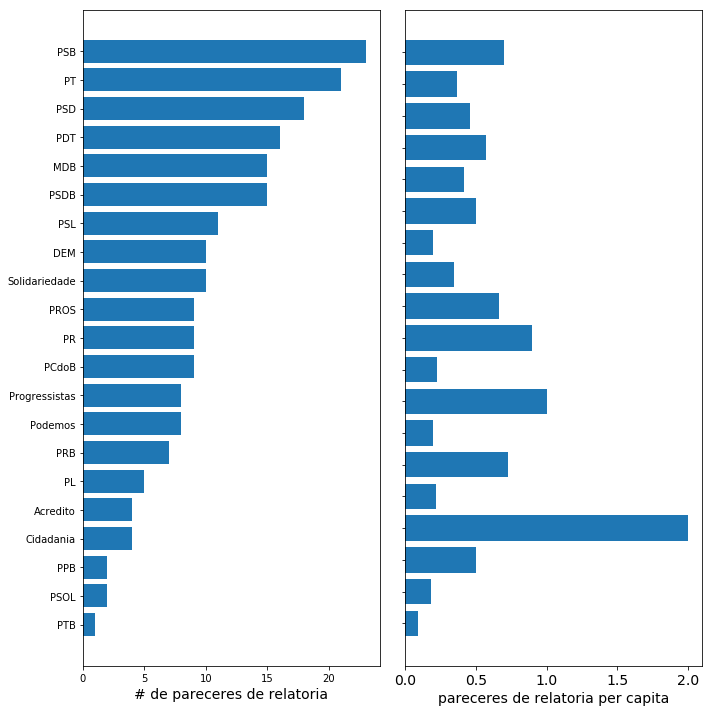

---------------
requerimentos de informação
---------------
Deputados
Posicao Tabata 73
Posicao Rigoni 204


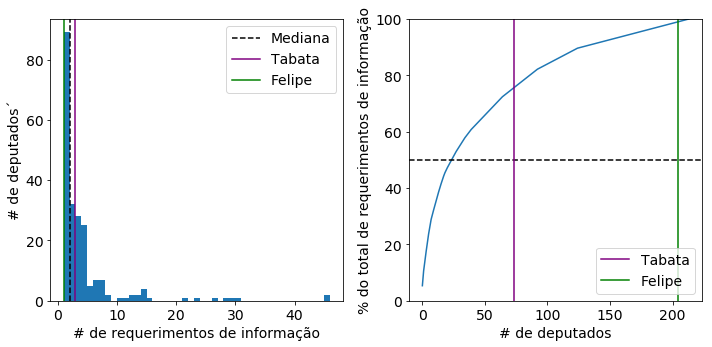

---------------
Partidos


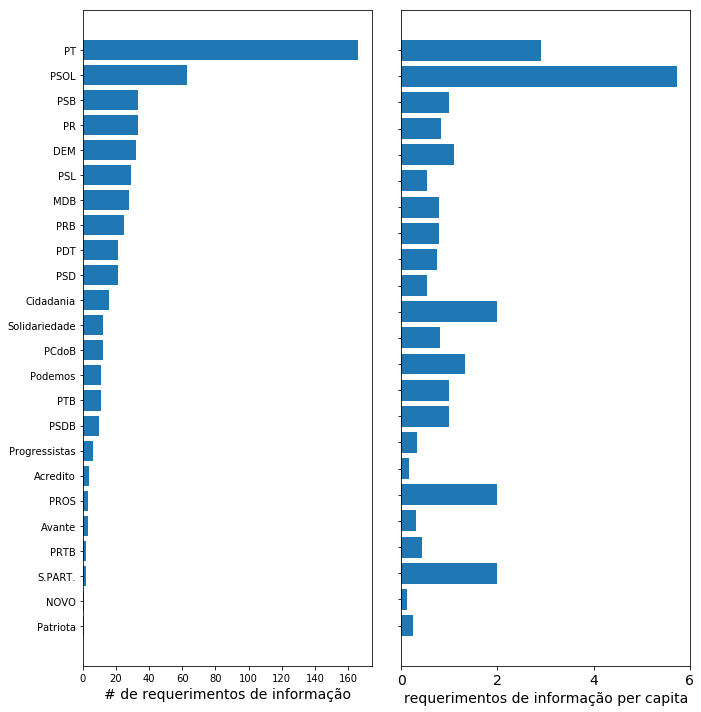

---------------
obstruções em plenário
---------------
Deputados


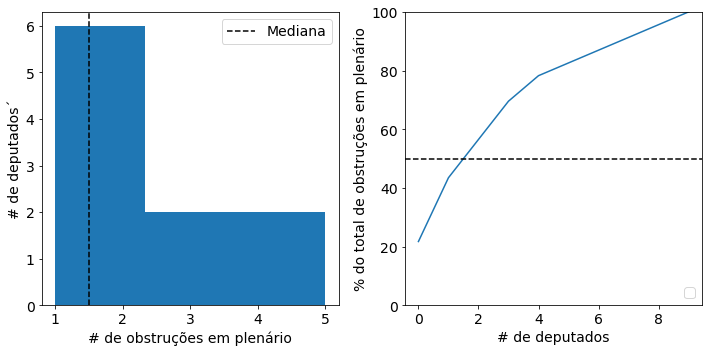

---------------
Partidos


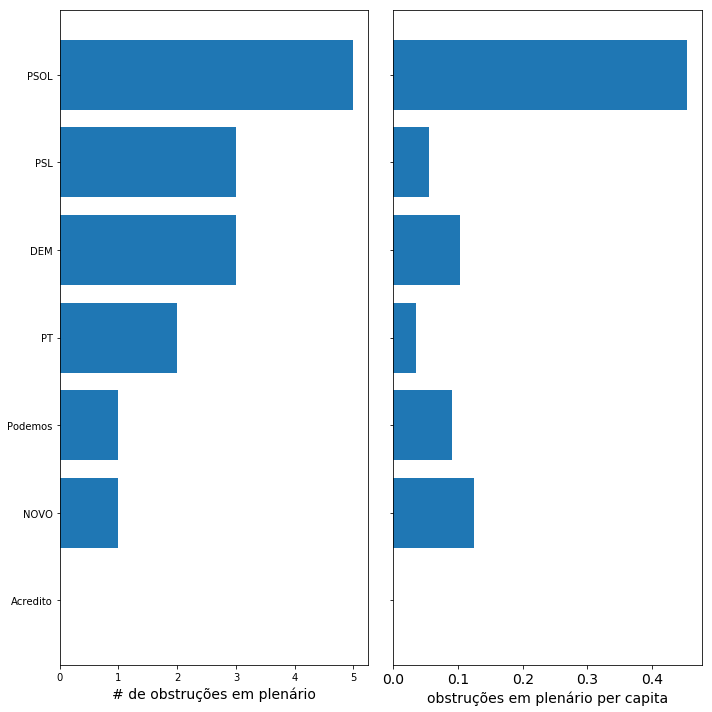

---------------
discussões de matéria
---------------
Deputados
Posicao Tabata 163
Posicao Rigoni 194


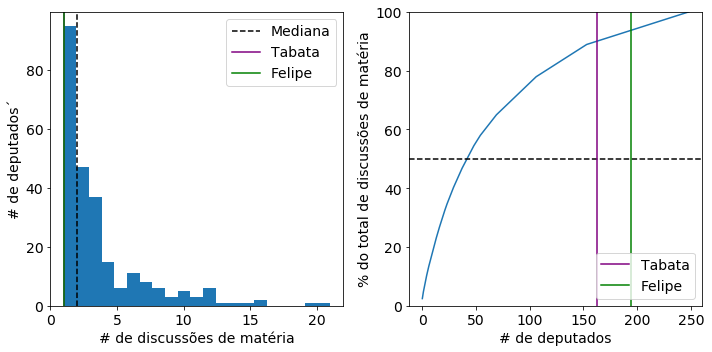

---------------
Partidos


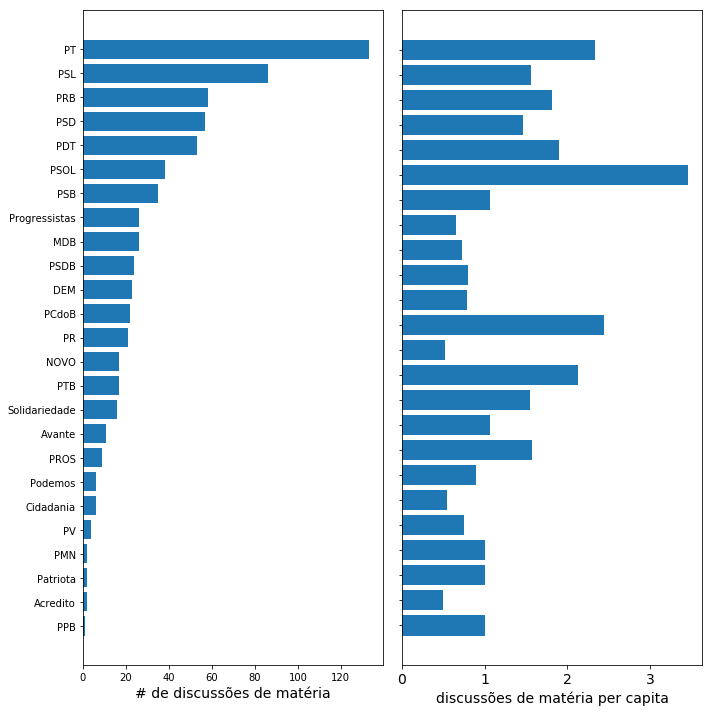

---------------
aprovações de requerimento
---------------
Deputados


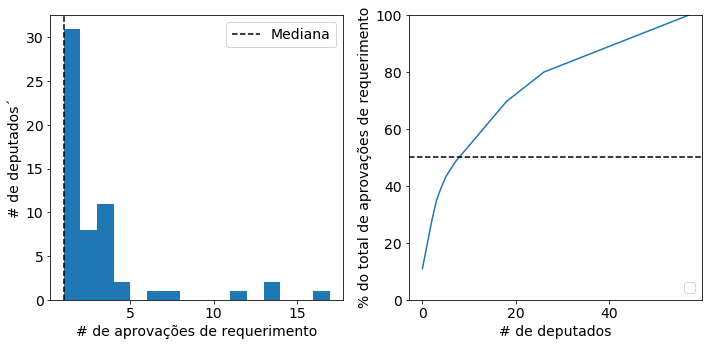

---------------
Partidos


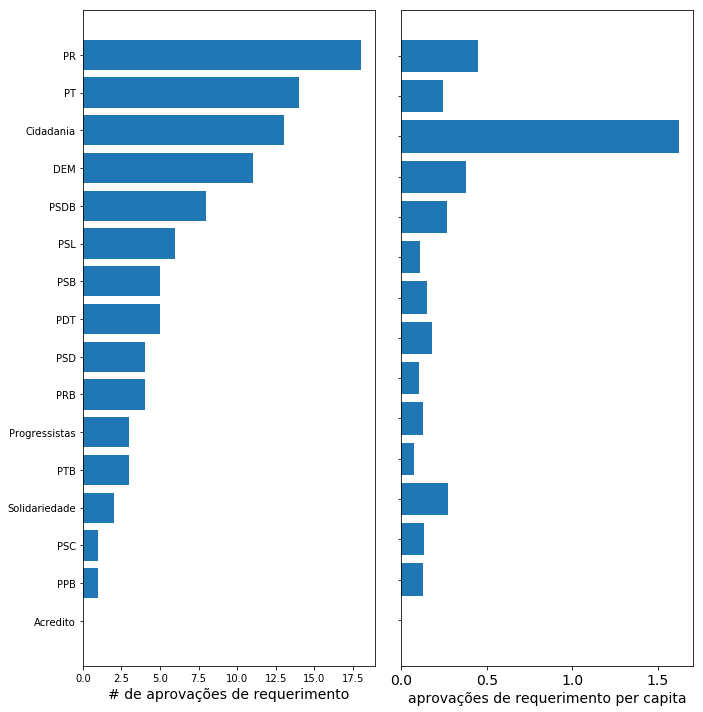

---------------
requerimento de audiência pública
---------------
Deputados
Posicao Tabata 254
Posicao Rigoni 284


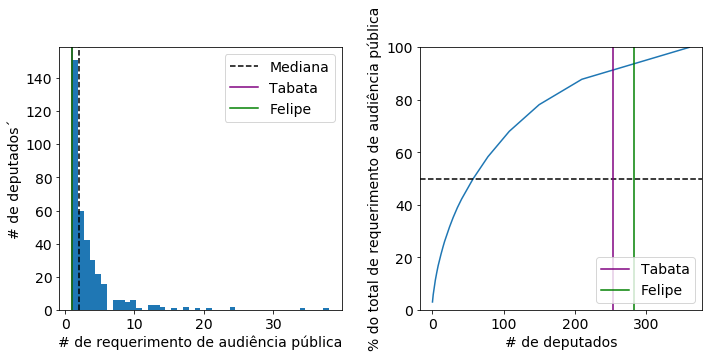

---------------
Partidos


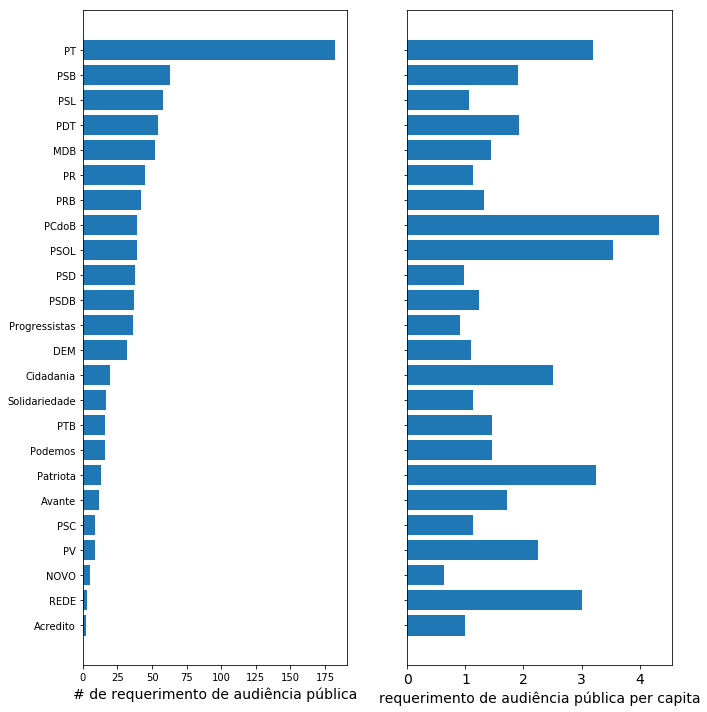

In [273]:
for acao in atividades_autores.keys():
    build_plots(atividades_autores, 
                acao, 
                partido_bancada, 
                tipo_atividade='autores')
    
for acao in atividades_tramitacao.keys():
    build_plots(atividades_tramitacao, 
                acao, 
                partido_bancada, 
                tipo_atividade='tramitacao')

In [274]:
final = pd.DataFrame()
for f in OUTPUT_PATH.glob('atividade/data/*_deputados.csv'):
    file = pd.read_csv(f)
    print(f.name.split('_')[0])
    file['acao'] = f.name.split('_')[0]
    final = pd.concat([final, file])

obstruções em plenário
apresentação REQ
apresentação PL
apresentação PDL
requerimento de audiência pública
aprovações de requerimento
pareceres de relatoria
requerimentos de informação
apresentação PEC
discussões de matéria
relatorias
apresentação PLC


In [275]:
final.head(3)

,Unnamed: 0,legislatura,nome_parlamentar,sigla_partido,acoes,acao
0,3,56,MARCEL VAN HATTEM,NOVO,1,obstruções em plenário
1,4,56,BIA KICIS,PSL,1,obstruções em plenário
2,7,56,ERIKA KOKAY,PT,1,obstruções em plenário


In [276]:
deputados_atividade = final.drop_duplicates(subset=[
                                                    'legislatura',
                                                    'nome_parlamentar', 
                                                    'acao'])\
 .pivot(index='nome_parlamentar', columns='acao', values='acoes')\
# .fillna(0)


In [277]:
deputados_atividade = deputados_atividade.merge(deputados[['nome_parlamentar']], left_index=True, right_on='nome_parlamentar', how='right')\
.set_index('nome_parlamentar').fillna(0)


In [278]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [279]:
acoes_sumario = deputados_atividade.sum().to_frame()
acoes_sumario.columns = ['# de Ações']
acoes_sumario['# de Deputados'] = deputados_atividade.apply(lambda x: x[x>0].count())
acoes_sumario['Mediana'] = deputados_atividade.apply(lambda x: x[x>0].median())
acoes_sumario['Gini Index'] = deputados_atividade.apply(gini).round(2)


In [280]:
acoes_sumario

,# de Ações,# de Deputados,Mediana,Gini Index
apresentação PDL,242,108,1.0,0.89
apresentação PEC,12,10,1.0,0.98
apresentação PL,2168,383,3.0,0.67
apresentação REQ,3591,489,5.0,0.52
aprovações de requerimento,88,27,2.0,0.98
discussões de matéria,639,198,2.0,0.80
obstruções em plenário,15,8,1.0,0.99
pareceres de relatoria,184,93,1.0,0.89
relatorias,1881,400,3.0,0.61
requerimento de audiência pública,751,241,2.0,0.75


In [281]:
print(acoes_sumario.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  \# de Ações &  \# de Deputados &  Mediana &  Gini Index \\
\midrule
apresentação PDL                  &         242 &             108 &      1.0 &        0.89 \\
apresentação PEC                  &          12 &              10 &      1.0 &        0.98 \\
apresentação PL                   &        2168 &             383 &      3.0 &        0.67 \\
apresentação REQ                  &        3591 &             489 &      5.0 &        0.52 \\
aprovações de requerimento        &          88 &              27 &      2.0 &        0.98 \\
discussões de matéria             &         639 &             198 &      2.0 &        0.80 \\
obstruções em plenário            &          15 &               8 &      1.0 &        0.99 \\
pareceres de relatoria            &         184 &              93 &      1.0 &        0.89 \\
relatorias                        &        1881 &             400 &      3.0 &        0.61 \\
requerimento de audiência pública &         751 

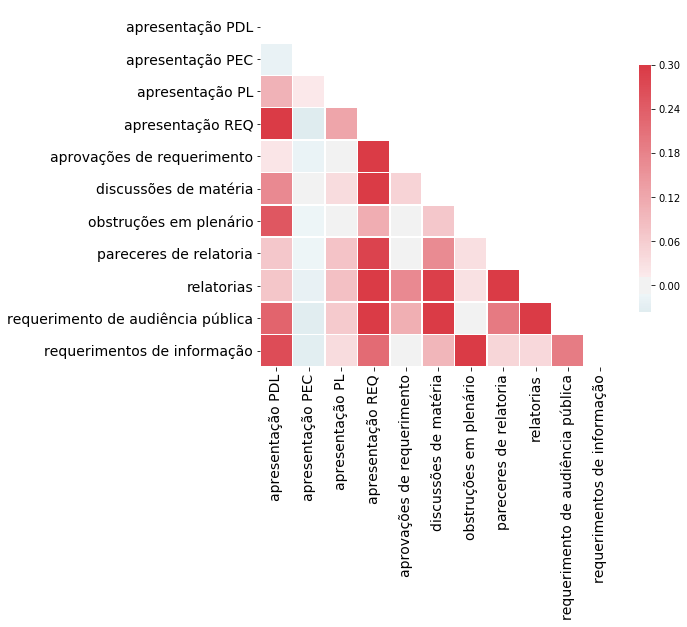

In [301]:
import seaborn as sns

corr = deputados_atividade.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            ax=ax)

ax.tick_params(labelsize=14)
f.tight_layout()
f.savefig(OUTPUT_PATH / 'atividade/fig/plot_corr_relatorias_deputados.png')

In [297]:
a = final.drop_duplicates(subset=[
                                'sigla_partido',
                                'nome_parlamentar',
                                'acao'])


## Parlamentares Ranking

In [224]:
ranking = deputados_atividade.sum(1).sort_values(ascending=False).to_frame()

## Apoio por Atividade

In [127]:
deputados_atividade = deputados_atividade.merge(deputados, left_index=True, right_on='nome_parlamentar', how='right')
deputados_atividade = deputados_atividade.set_index('id')
del deputados_atividade['nome_parlamentar']

In [147]:
apoio = query_gcp("SELECT * FROM `gabinete-compartilhado.paineis.apoio_ao_governo_por_deputado`")

In [148]:
apoio.head()

,id_deputado,n_votacoes,apoio_governo
0,141428,9,1.000000
1,141459,21,1.000000
2,204545,24,1.000000
3,141439,23,0.260870
4,160598,19,0.684211


In [150]:
deputados_atividade = deputados_atividade.merge(apoio, left_index=True, right_on='id_deputado').set_index('id_deputado')
del deputados_atividade['n_votacoes']

### Cumsum

In [172]:
deputados_atividade['deputado_numb'] = 1
deputados_atividade = deputados_atividade.sort_values(by='apoio_governo')

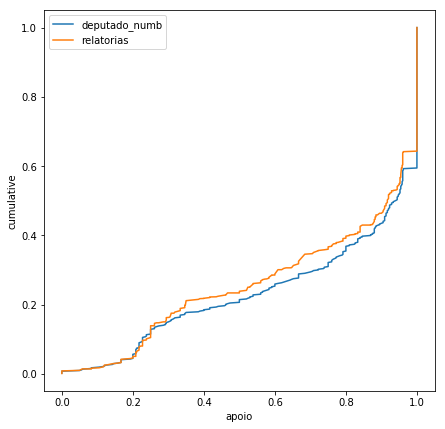

In [192]:
pl.figure(figsize=(7, 7))

pl.plot(deputados_atividade['apoio_governo'], 
        deputados_atividade['deputado_numb'].cumsum().divide(deputados_atividade['deputado_numb'].sum()),)
pl.plot(deputados_atividade['apoio_governo'], deputados_atividade['relatorias'].cumsum().divide(deputados_atividade['relatorias'].sum()))

pl.xlabel('apoio')
pl.ylabel('cumulative')

pl.legend()
